VAE model pretrain on MPII

In [ ]:
# run in colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Colab/ActionReplay')
!pwd

In [1]:
# prepare data
from torch.utils.data import DataLoader, random_split
from data_utils import *

data = MPIIDataSet('datasets/mpii_human_pose_v1')
data_size = len(data)

train_size = data_size * 9 // 10
print("Train size: ", train_size)
val_size = data_size - train_size
batch_size = 32

train_set, val_set = random_split(data, [train_size, val_size])

train_data_loader = DataLoader(train_set,
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers=4)
val_data_loader = DataLoader(val_set,
                             batch_size=1,
                             shuffle=True,
                             num_workers=4)

Train size:  22485


In [2]:
from vae import VAE
from torch import optim

device = 'cuda'
log_interval = 500
epochs = 2
model = VAE(latent_dim=512).to(device)
optimizer = optim.Adam([
    {'params': model.encoder.parameters(), 'lr': 5e-4},
    {'params': model.fc_mu.parameters()},
    {'params': model.fc_logvar.parameters()},
    {'params': model.sampler.parameters()},
    {'params': model.decoder.parameters()}
], lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                             gamma=0.8)

for epoch in range(epochs):
    for i, batch in enumerate(train_data_loader):
        img = batch.to(device)
        gen = model(img)
        loss, recon_loss, kld_loss = model.loss_function(*gen, M_N=batch_size/train_size)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i % log_interval == log_interval-1):
            print("RECON Loss: {}, KLD loss:{}".format(float(recon_loss.cpu()), float(kld_loss.cpu())))
    scheduler.step()
torch.save(model.state_dict(), 'models/vae_mark1.pth')

KeyboardInterrupt: 

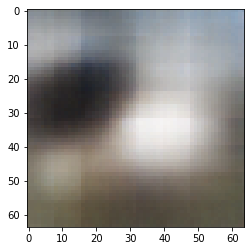

In [14]:
model.load_state_dict(torch.load('models/vae_mark1.pth'))
model.eval()
fig, axs = plt.subplots(1, 2)
# sample = model.sample(num_samples = 1,
#                       current_device = device)[0].permute(1, 2, 0)
# axs[0].imshow(sample.cpu().detach().numpy())
for batch in val_data_loader:
    img = batch
    img_show = img.squeeze(0).permute(1, 2, 0)
    axs[0].imshow(img_show.detach().numpy())
    gen = model(img.to(device))[0].squeeze(0).permute(1, 2, 0)
    axs[1].imshow(gen.cpu().detach().numpy())
    plt.pause(-1)